In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns

In [3]:
# Ray Data from S3 (1 + 1)
data_s3_1_1 = pd.read_csv("../image_training/e2e_training/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/e2e_training_s3_g5_xlarge_batch_256.csv")

# Ray Data from Local (Single Node)
ray_local = pd.read_csv("../image_training/e2e_training/_LOCAL ray single node/e2e_training_s3_g5_xlarge_batch_256.csv")

# tf.data from Local
tf_32 = pd.read_csv("../image_training/e2e_training/_TF 32/tf_data_e2e_training_g5_xlarge_batch_32.csv")
tf_256 = pd.read_csv("../image_training/e2e_training/_TF 256/tf_data_e2e_training_g5_xlarge_batch_256.csv")

tf_s3_32 =  pd.read_csv("../image_training/e2e_training/_TF_S3 32/tf_data_e2e_training_g5_xlarge_batch_32.csv")

Calculate theoretical max

In [4]:
import json

with open('/home/ubuntu/ray-data-eval/ray_data_eval/image_training/e2e_training/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/ray_data_training_cluster_s3_b_256_gpu.json', 'r') as f:
    data = json.load(f)

total_gpu_time = 0
for i in range(0, len(data), 2):
    total_gpu_time += (data[i+1]['ts'] - data[i]['ts']) / 1e6

print("Total GPU time:", total_gpu_time)
print("Theoretical max throughput:", 1281167 / total_gpu_time)

Total GPU time: 3376.8104902500045
Theoretical max throughput: 379.40151030067074


In [5]:
def process(data, resample="60s"):
    data = data.copy()
    data["time_from_start"] = pd.to_timedelta(data["time_from_start"], unit="s")
    data.set_index("time_from_start", inplace=True)
    data["tput"] = data["number_of_rows_finished"].diff() / data.index.total_seconds().diff()
    data["tput"] = data["tput"].fillna(0)
    avg_tput = np.mean(data["tput"])
    # tput_resampled = data['tput'].resample(resample).bfill()
    tput_resampled = data["tput"].resample(resample).mean().bfill()
    idx = [(item.total_seconds() // 60) for item in tput_resampled.index]
    return idx, tput_resampled.values, avg_tput

In [6]:
idx_ray_local, values_ray_local, _ = process(ray_local)

avg_ray_local = (
    ray_local.iloc[-1]["number_of_rows_finished"] / ray_local.iloc[-1]["time_from_start"]
)

avg_ray_local

343.09494024057716

In [7]:
idx_tf_32, values_tf_32, _ = process(tf_32)

avg_tf_32 = (
    tf_32.iloc[-1]["number_of_rows_finished"] / tf_32.iloc[-1]["time_from_start"]
)

avg_tf_32

318.61288366893064

In [25]:
idx_tf_s3_32, values_tf_s3_32, _ = process(tf_s3_32)

avg_tf_s3_32 = (
    tf_s3_32.iloc[-1]["number_of_rows_finished"] / tf_s3_32.iloc[-1]["time_from_start"]
)

avg_tf_s3_32

44.04948149361676

In [9]:
idx_tf_256, values_tf_256, _ = process(tf_256)

avg_tf_256 = (
    tf_256.iloc[-1]["number_of_rows_finished"] / tf_256.iloc[-1]["time_from_start"]
)

avg_tf_256

305.97009645381877

In [10]:
idx_s3_1_1, values_s3_1_1, _ = process(data_s3_1_1)

avg_s3_1_1 = (
    data_s3_1_1.iloc[-1]["number_of_rows_finished"] / data_s3_1_1.iloc[-1]["time_from_start"]
)

avg_s3_1_1

351.9184216299524

In [11]:
from datetime import datetime

with open('/home/ubuntu/ray-data-eval/ray_data_eval/image_training/e2e_training/_FAULT [1x] g5.xlarge + [1x] m7i.2xlarge/killed-workers-time.out', 'r') as f:
    lines = f.readlines()

start_time = 1714861597.939253
timestamps = []
for line in lines:
    line = line[:-1]
    dt = datetime.strptime(line, '%Y-%m-%d %H:%M:%S,%f')
    timestamps.append(dt.timestamp() - start_time)
timestamps = pd.to_timedelta(pd.Series(timestamps), unit="s")
timestamps = [(item.total_seconds() / 60) for item in timestamps]
timestamps[:5]

[4.1412791,
 6.185995766666666,
 7.159729100000001,
 9.4965791,
 11.187162433333333]

In [12]:
THEORETICAL_MAX = 1281167 / total_gpu_time

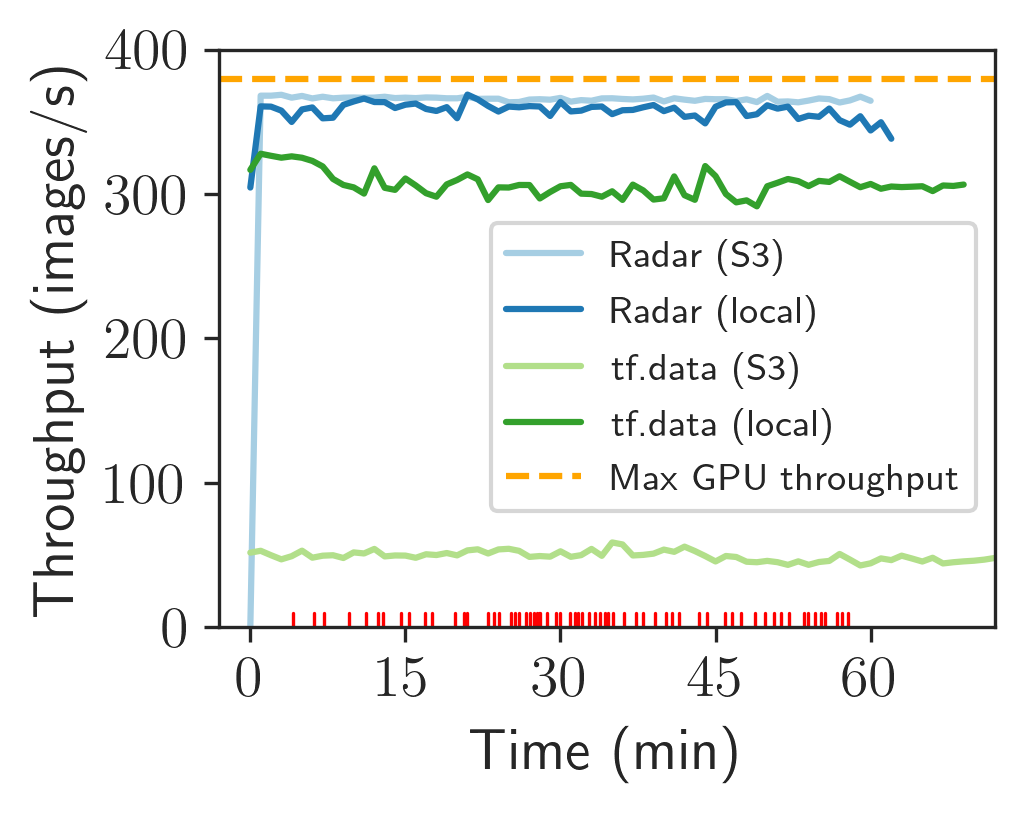

In [41]:
FIGRATIO = 3 / 4
FIGWIDTH = 3.335  # inches
FIGHEIGHT = FIGWIDTH * FIGRATIO
FIGSIZE = (FIGWIDTH, FIGHEIGHT)
BIG_SIZE = 14

COLORS = sns.color_palette("Paired")
sns.set_style("ticks")
sns.set_palette(COLORS)

plt.rcParams.update(
    {
        "figure.figsize": FIGSIZE,
        "figure.dpi": 300,
        "text.usetex": True,
    }
)
plt.rc("font", size=BIG_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()

ax.plot(idx_s3_1_1, values_s3_1_1, label="Radar (S3)")
ax.plot(idx_ray_local, values_ray_local, label="Radar (local)")
ax.plot(idx_tf_s3_32, values_tf_s3_32, label="tf.data (S3)")
ax.plot(idx_tf_256, values_tf_256, label="tf.data (local)")

ax.axhline(
    y=THEORETICAL_MAX, color="orange", linestyle="--", label="Max GPU throughput"
)

for timestamp in timestamps:
    ax.axvline(x=timestamp, ymin=0/400, ymax=10/400, color="red", linestyle="-", linewidth=0.8, alpha=1.0)
    # ax.scatter(timestamps, [0]*len(timestamps), color='red', s=1)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))

plt.xlabel("Time (min)")
plt.ylabel("Throughput (images/s)")
plt.ylim(0, 400)
plt.xlim(-3, 72)
plt.legend(fontsize=9, loc='center right', bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
plt.savefig("image-training.pdf", bbox_inches='tight')